## Champions League last 16 recursion

<br/>
<figure>
<img src="./img/urn.jpg"/>
</figure>

Tomorrow, Monday, Dec 17th, top sixteen european football clubs await their opponents in the knock-out stages in the UEFA Champions League. <a href="https://www.uefa.com/uefachampionsleague/season=2019/draws/round=2000981/">The draw is scheduled for 12pm</a>.

What's interesting about the draw is that the pairs are not drawn completely at random. The pot is separated into group winners and runners-up, where the teams advancing from the same group cannot meet each other in the last 16 stage. Additionally, teams from the same country cannot play each other at this stage.

These constraints lead to an interesting non-uniform distribution over possible pairs. Here, we design a simple recursive algorithm to assign probabilities for each pair.

An interesting situation happened <a href="https://www.facebook.com/photo.php?fbid=10155397869534671&set=a.384846034670&type=3&theater">last year</a>; Barcelona finished first in its group, while other Spanish teams finished second. Chelsea, on the other hand, finished second, while other English clubs won their groups. It meant that Barcelona and Chelsea were destined to meet at at strikingly high 43% probability. After the draw, Barca actually got Chelsea (Messi&co then easily dispatched the opponents over two legs).

This year does not contain such an extreme situation, however some teams can already start preparing for the kind of opponent they are likely to get.



Let's start by importing the dynamic duo, numpy and matplotlib.

In [2]:
import numpy as np
import matplotlib.pyplot as plt

This year, the following teams are involved:

<b>Group winners</b>: Barcelona (ESP, Group B), Bayern München (GER, E),
Borussia Dortmund (GER, A), Juventus (ITA, H), Manchester City (ENG, F),
Paris Saint-Germain (FRA, C), Porto (POR, D), Real Madrid (ESP, holders, G).

<b>Group runners-up</b>:
Ajax (NED, E), Atlético Madrid (ESP, A), Liverpool (ENG, C), Lyon (FRA, F), Manchester United (ENG, H), Roma (ITA, G), Schalke (GER, D), Tottenham Hotspur (ENG, B).


We can represent this data as a binary matrix, indicating which teams are eligible to play each other:

In [3]:
# Data matrix
X = np.array([
       #AJA #ATM  #LIV  #LYO  #MUN  #ROM  #SCH  #TOT
       [1,  0,    1,    1,    1,    1,    1,    0], #BAR
       [0,  1,    1,    1,    1,    1,    0,    1], #BAY
       [1,  0,    1,    1,    1,    1,    0,    1], #BOR
       [1,  1,    1,    1,    0,    0,    1,    1], #JUV
       [1,  1,    0,    0,    0,    1,    1,    0], #MCI
       [1,  1,    0,    0,    1,    1,    1,    1], #PSG
       [1,  1,    1,    1,    1,    1,    0,    1], #POR
       [1,  0,    1,    1,    1,    0,    1,    1]  #REA
    ])

# Name rows and columns for show
rownames = ["Barcelona", "Bayern M.", "Borussia D.", "Juventus", "Manchester C.", "Paris S.G.", "Porto", "Real M."]
colnames = ["Ajax", "Atletico M.", "Liverpool", "Lyon", "Manchester U.", "Roma", "Schalke 04", "Tottenham H."]

The more zeros team A has in its row/column, the more probability mass will be put to other candidates to meet team A. We can already see that Manchester City will likely meet Atletico Madrid. But exactly how likely? 

We design a fairly simple recursive algorithm that enumerates each possible path through the draw. It would be sufficient to simply count the permutations and discard invalid ones, but this seems an intuitive way if one needs to list all the draws. 


We will use a stack that simulates recursive calls to a function, that adds each possible group-winner to a runner-up one step at a time. If the path reaches the end, we found a valid draw outcome and the probabilities of pairs are increased accordingly. Otherwise, the path building stops and the candidate path is discarded.



In [4]:
def matrix2sets(X):
    """ Convert a data matrix to list of sets. """
    n = X.shape[0]
    data = [set({}) for i in range(n)]
    for r, c in zip(*np.where(X)):
        data[r].add(c)
    return data

Our path data structure contains the current path, the set of nodes on the current path (for more efficient set operations), and the next position to look at.

In [5]:
class Candidate:
    path = None     # Ordered nodes
    nodes = None    # All nodes
    pos = None      # Next position to look

    def __init__(self):
        self.path = []
        self.nodes = set([])
        self.pos = 0


The solution is fairly simple to read; A dummy candidate path is constructed at the beggining, and new nodes are added in each step until the path terminates (we found a valid draw outcome) or there are no more possible opponents for the partly built path.

In [6]:
# Solution with tail recursion
def process(data):
    """ Return a count matrix of how often each pair appears in the path. """

    # Add an empty path to stack
    stack = [Candidate()]
    n = len(data)

    # Counter matrix
    C = np.zeros((len(data), len(data)))

    # Keep extending paths until hitting end or
    #  no options to extend
    while not len(stack) == 0:
        curr = stack.pop()
        if curr.pos == n:
            C[(list(range(n)),
               curr.path)] += 1
            continue

        # Create new candidate paths
        nodes = data[curr.pos] - curr.nodes
        for no in nodes:
            new = Candidate()
            new.path = curr.path + [no]
            new.nodes = curr.nodes | {no}
            new.pos = curr.pos + 1
            stack.append(new)

    return C

After obtaining the result, we convert the counts into probabilities.

In [10]:
data = matrix2sets(X)
C = process(data)
P = 100 * np.round((C / C.sum(axis=0)), 2)
P

array([[14.,  0., 17., 17., 17., 16., 18.,  0.],
       [ 0., 18., 17., 17., 17., 15.,  0., 17.],
       [14.,  0., 18., 18., 18., 16.,  0., 18.],
       [13., 19., 17., 17.,  0.,  0., 18., 17.],
       [20., 29.,  0.,  0.,  0., 23., 28.,  0.],
       [14., 19.,  0.,  0., 17., 16., 18., 17.],
       [12., 16., 15., 15., 15., 14.,  0., 15.],
       [14.,  0., 17., 17., 17.,  0., 18., 17.]])

Finally, let's add a plotting function to read our result.

In [17]:
def hm(D, rownames, colnames):
    """ Heatmap for a data matrix D annotated with text."""
    plt.figure(figsize=(8, 8))
    heatmap = plt.pcolor(D, vmin=0, vmax=66)
    for y in range(D.shape[0]):
        for x in range(D.shape[1]):
            if D[y, x]:
                plt.text(x + 0.5, y + 0.5, '%.1f' % D[y, x],
                         horizontalalignment='center',
                         verticalalignment='center',)
    cb = plt.colorbar(heatmap)
    cb.set_label("Probability (%)", horizontalalignment='center')
    n = len(D)
    ax = plt.gca()
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    plt.gca().set_xticks(np.linspace(0.5, n-0.5, n))
    plt.gca().set_yticks(np.linspace(0.5, n-0.5, n))
    plt.gca().set_xticklabels(colnames, rotation=90)
    plt.gca().set_yticklabels(rownames)
    plt.xlim(0, n)
    plt.ylim(0, n)
    plt.show()

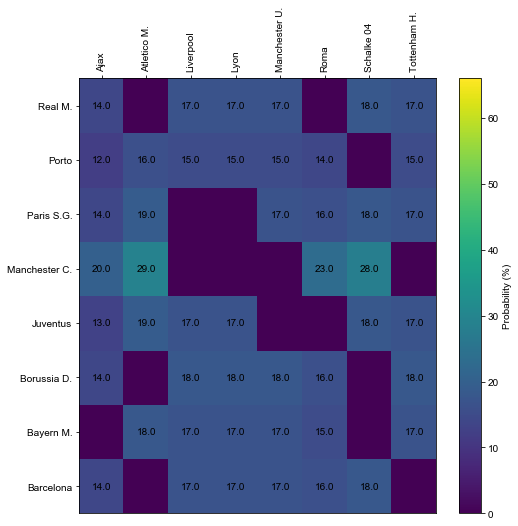

In [18]:
hm(P, rownames, colnames)

Looks like Atletico will most likely face a tough trip to the north of England, where we would see two most contrasting teams. Manchester City  made the most of their group stage; avoiding Atletico they would likely progress easily. 

Elsewhere, Manchester United really messed up their chances of progressing by finishing second. They will now face one of the European big dogs, as the chances to get Porto are very small.

For exercise, one can re-run this algorithm on the more complex, Europa league last-32 stage!